In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from hmmlearn import hmm

from vdata import Folio, Voynich

In [41]:
# the document
text = "The quick brown fox jumped over the lazy dog".lower().split()

def tokenize(text):
    """
    text is an array of stuff
    """
    tokens = set(text)
    token2int = {t:i for i,t in enumerate(tokens)}
    int2token = {i:t for t,i in token2int.items()}
    text = [token2int[t] for t in text]
    
    return text, token2int, int2token

text, word_index, index_word = tokenize(text)
word_index

{'brown': 1,
 'dog': 7,
 'fox': 5,
 'jumped': 4,
 'lazy': 6,
 'over': 3,
 'quick': 0,
 'the': 2}

In [67]:
a = Voynich()

# grab lines that are over 4 words long
lines = list(a.data[a.data.words > 4].text)

# input: a list of words that we want to tag
text = ' '.join(lines).split()
text, word_index, index_word = tokenize(text)
X = np.array(text).reshape(-1,1)
print(X.shape)

# fit a 2-state HMM 
remodel = hmm.MultinomialHMM(n_components=2, n_iter=300)
remodel.fit(X)
predictions = remodel.predict(X)
print('done!')

# get the tags

(34991, 1)


/home/cz/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py:405: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/home/cz/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/home/cz/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


done!


/home/cz/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),


In [68]:
tags = pd.DataFrame({
    'index': X.flatten(),
    'tag': predictions
})
A_words =[index_word[t] for t in tags[tags.tag == 1]['index']]
B_words =[index_word[t] for t in tags[tags.tag == 0]['index']]
with open('A_words.txt', 'w') as f:
    f.write(' '.join(A_words))
with open('B_words.txt', 'w') as f:
    f.write(' '.join(B_words)) 

In [69]:
remodel.transmat_

array([[0.9642243 , 0.0357757 ],
       [0.04844456, 0.95155544]])

What does this mean?
* if you're in state A, you're likely to see these words a lot
* you're also 5% going to switch to state B... and see the other words

In [70]:
with open('A_words.txt') as f:
    a_words = f.read().split()
with open("B_words.txt") as f:
    b_words = f.read().split()

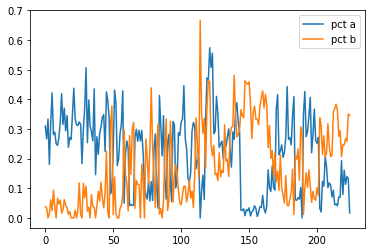

In [71]:
import pandas as pd
from collections import Counter

a = Voynich()

data = []
for folio in a.folios:
    tex = a.getWords(folio)
    original_len = len(tex.split())
    
    b = Counter(tex.split()) - Counter(a_words)
    af = Counter(tex.split()) - Counter(b_words)
    
#     print(b, sum(b.values()))
    if original_len > 0:
        data.append(
            (sum(b.values()) / original_len,
             sum(af.values()) / original_len))
    else:
        data.append((0,0))

data = pd.DataFrame({
    'folio': a.folios,
    'pct b': [x[0] for x in data],
    'pct a': [x[1] for x in data]
})
data.plot()